In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
from astropy.io import ascii
from astropy import table

from astropy import cosmology
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt

import SAGA  
from SAGA import ObjectCuts as C

from easyquery import QueryMaker
from easyquery import Query
from SAGA.database import FitsTable 

from SAGAbg.utils import calc_kcor
from SAGAbg import SAGA_get_spectra
import namer

In [3]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
# SET UP SAGA STUFF
dropbox_directory = '/Users/kadofong/DropBox/SAGA/'
saga = SAGA.QuickStart(local_dir='../local_data/',\
                       shared_dir=dropbox_directory)

#hostlist     = saga.host_catalog.load(include_stats='remote',query='good')


SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


In [5]:
names = np.genfromtxt('../local_data/naming/names.txt', dtype=str)

In [6]:
saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"
saga.database["combined_base"].download(overwrite=False)

base = saga.object_catalog.load_combined_base_catalog()
base['wordid'] = names[:,1]
#base = saga.host_catalog.construct_host_query("paper3").filter(base)

cleaner = (base['REMOVE']==0)&base['is_galaxy']&(base['g_mag']<30.)&(base['r_mag']<30.)#&(base['ZQUALITY']>=3)
clean = base[cleaner].copy()

clean['selection'] = 0
cuts = SAGA.objects.cuts
SAGA.utils.fill_values_by_query(clean, cuts.main_targeting_cuts, {'selection':3})
SAGA.utils.fill_values_by_query(clean, cuts.paper1_targeting_cut&~cuts.main_targeting_cuts, {'selection':2})
SAGA.utils.fill_values_by_query(clean, ~cuts.main_targeting_cuts&~cuts.paper1_targeting_cut, {'selection':1})
#clean = clean.to_pandas ()

286539

In [7]:
clean.add_index('wordid')

In [8]:
first_objects = clean[(clean['selection']==3)&(clean['ZQUALITY']>=3)&((clean['TELNAME']=='AAT')|(clean['TELNAME']=='MMT'))]
all_the_good_spectra = clean[(clean['ZQUALITY']>=3)&((clean['TELNAME']=='AAT')|(clean['TELNAME']=='MMT'))]

In [9]:
obj = first_objects[np.where(np.in1d(first_objects['OBJID'], 902548960000004877))[0][0]]

In [10]:
fake_nbwidth = 10.

In [11]:
line_wavelengths = {'Halpha':6563.,'OIII4363':4363., 'Hbeta':4861., }#'OIII5007':5007}
cont_wavelengths = {'Halpha':6650., 'OIII4363':4400., 'Hbeta':4880.,}# 'OIII5007':5100}


In [28]:
ok = ['hurdle_dam','upkeep_transposed','deluging_trophy', 'evolutionary_thebes']

In [15]:
obj = clean.loc['cableway_doorstep'] #['mcinnes_aapg_arrogance']

In [16]:
print(f"{obj['RA']}d {obj['DEC']}d")

0.8706363367124569d 20.755133784280865d


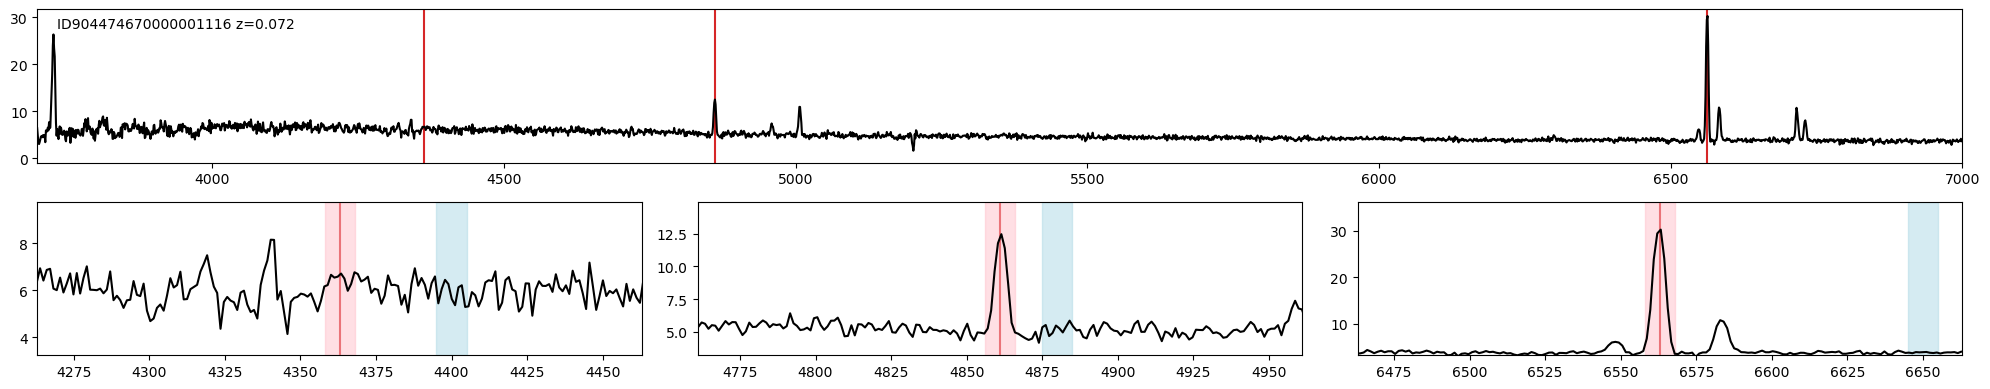

In [17]:
flux, wave, ivar, flag = SAGA_get_spectra.saga_get_spectrum(obj, dropbox_directory)
#binned_flux = flux.reshape(-1,2).mean(axis=1)
#binned_wv = wave.reshape(-1,2).mean(axis=1)

restwv = wave/(1.+obj['SPEC_Z'])
objname = obj['OBJID']
axorder = {'OIII4363':0, 'Hbeta':1, "Halpha":2}
delta =100.

fig = plt.figure ( figsize=(20,4))

shape = (2,3)
ax_prince = plt.subplot2grid ( shape, (0,0), colspan = 3 )
line_axes = [ plt.subplot2grid(shape, (1,idx)) for idx in range(3) ]
axarr = [ax_prince] + line_axes
ylim = np.nanquantile(flux[(restwv>3700.)&(restwv<=7000.)], [0.01, 1.])
ylim[1] = ylim[1] * 1.1
for ax in axarr:
    ax.plot(restwv,flux,color='k')    
    #ax.plot(binned_wv/(1.+obj['SPEC_Z']), binned_flux, color='k')
for key in line_wavelengths:   
    ax = axarr[axorder[key]+1]
    ax_prince.axvline(line_wavelengths[key], color='tab:red', zorder=0)
    ax.axvline(line_wavelengths[key], color='tab:red', zorder=0)
    ax.axvspan ( line_wavelengths[key]-fake_nbwidth/2., line_wavelengths[key]+fake_nbwidth/2., color='pink', alpha=0.5 )
    ax.axvspan ( cont_wavelengths[key]-fake_nbwidth/2., cont_wavelengths[key]+fake_nbwidth/2., color='lightblue', alpha=0.5 )        
    ymax = np.nanquantile(flux[abs((restwv) - line_wavelengths[key]) <= (2.*delta)], 1.) * 1.2
    ax.set_ylim(ylim[0], ymax)
delta = 100.        
axarr[1].set_xlim(line_wavelengths['OIII4363'] - delta, line_wavelengths['OIII4363'] + delta )
axarr[2].set_xlim(line_wavelengths['Hbeta'] - delta, line_wavelengths['Hbeta'] + delta )
axarr[3].set_xlim(line_wavelengths['Halpha'] - delta, line_wavelengths['Halpha'] + delta )
ax_prince.text ( 0.01, 0.95, f'ID{objname} z={obj["SPEC_Z"]:.3f}', transform=ax_prince.transAxes, ha='left', va='top')

ax_prince.set_xlim(3700.,7000.)
plt.tight_layout ()

In [21]:
#line_wavelengths = {'Halpha':6563.,'OIII4363':4363., 'Hbeta':4861., 'OIII5007':5007}
delta = 200

for name,row in lineflux_df.query('(OIII4363>1.)&(Halpha>10.)').iterrows():
    obj = clean.loc[name]
    if isinstance(obj, table.Table):
        obj = obj[0]
        
    flux, wave, ivar, flag = SAGA_get_spectra.saga_get_spectrum(obj, dropbox_directory)
    #binned_flux = flux.reshape(-1,2).mean(axis=1)
    #binned_wv = wave.reshape(-1,2).mean(axis=1)

    restwv = wave/(1.+obj['SPEC_Z'])
    objname = obj['OBJID']
    axorder = {'OIII4363':0, 'Hbeta':1, "Halpha":2}
    figname = f'../figures/exploration/spectra/spectrum_ID{name}.png'


    fig = plt.figure ( figsize=(20,4))
    shape = (2,3)
    ax_prince = plt.subplot2grid ( shape, (0,0), colspan = 3 )
    line_axes = [ plt.subplot2grid(shape, (1,idx)) for idx in range(3) ]
    axarr = [ax_prince] + line_axes
    ylim = np.nanquantile(flux[(restwv>3700.)&(restwv<=7000.)], [0.01, 1.])
    ylim[1] = ylim[1] * 1.1
    for ax in axarr:
        ax.plot(restwv,flux,color='k')    
        #ax.plot(binned_wv/(1.+obj['SPEC_Z']), binned_flux, color='k')
    for key in line_wavelengths:   
        ax = axarr[axorder[key]+1]
        ax_prince.axvline(line_wavelengths[key], color='tab:red', zorder=0)
        ax.axvline(line_wavelengths[key], color='tab:red', zorder=0)
        ax.axvspan ( line_wavelengths[key]-fake_nbwidth/2., line_wavelengths[key]+fake_nbwidth/2., color='pink', alpha=0.5 )
        ax.axvspan ( cont_wavelengths[key]-fake_nbwidth/2., cont_wavelengths[key]+fake_nbwidth/2., color='lightblue', alpha=0.5 )        
        ymax = np.nanquantile(flux[abs((restwv) - line_wavelengths[key]) <= (2.*delta)], 1.) * 1.2
        ax.text ( 0.025, 0.95, f'key: {lineflux_df.loc[name, key]:.1f}', ha='left', va='top', transform=ax.transAxes )
        ax.set_ylim(ylim[0], ymax)
    #delta = 100.        
    axarr[1].set_xlim(line_wavelengths['OIII4363'] - delta, line_wavelengths['OIII4363'] + delta )
    axarr[2].set_xlim(line_wavelengths['Hbeta'] - delta, line_wavelengths['Hbeta'] + delta )
    axarr[3].set_xlim(line_wavelengths['Halpha'] - delta, line_wavelengths['Halpha'] + delta )
    ax_prince.text ( 0.01, 0.95, f'{name} z={obj["SPEC_Z"]:.3f}', transform=ax_prince.transAxes, ha='left', va='top')

    ax_prince.set_xlim(3700.,7000.)
    plt.tight_layout ()
    
    plt.savefig(figname)
    plt.close ()


KeyboardInterrupt: 

In [28]:
kcorrect = calc_kcor.calc_kcor

distmod = cosmo.distmod(clean['SPEC_Z']).value
real_kcorrect_g = kcorrect ( 'g', clean['SPEC_Z'],'gr', clean['gr'])
clean['Mg'] = clean['g_mag'] - distmod - real_kcorrect_g 
clean["Kg"] = real_kcorrect_g
real_kcorrect_r = kcorrect ( 'r', clean['SPEC_Z'], 'gr', clean['gr'])
clean['Mr'] = clean['r_mag'] - distmod - real_kcorrect_r
clean["Kr"] = real_kcorrect_r
real_kcorrect_z = kcorrect ( 'z', clean['SPEC_Z'], 'rz', clean['rz'])
clean['Mz'] = clean['z_mag'] - distmod - real_kcorrect_z 
clean["Kz"] = real_kcorrect_z

logml = 1.65 * (clean['Mg']-clean['Mr']) - 0.66
clean['cm_logmstar'] = logml + (clean['Mg']-5.11)/-2.5

/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:347: RuntimeWarning: divide by zero encountered in true_divide
  self._T_hypergeometric(s / (z2 + 1.0)))
/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)


In [31]:
clean.loc['hurdle_dam']['cm_logmstar']

11.001273089278882

In [32]:
tentative_detections = lineflux_df.query('(OIII4363>1.)&(Halpha>10.)')

In [48]:
df = clean.to_pandas()#.set_index('wordid')

(-10.0, -24.0)

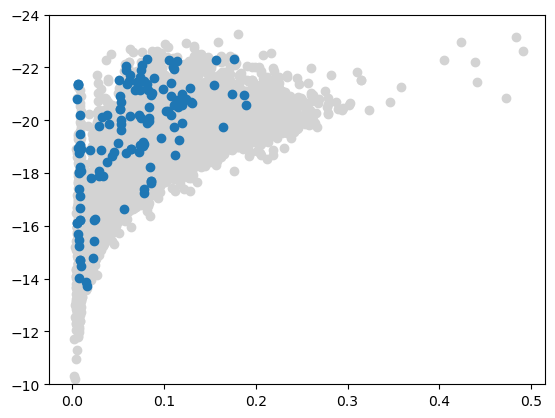

In [55]:
plt.scatter ( first_objects['SPEC_Z'], first_objects['Mr'], color='lightgrey')
plt.scatter (df.reindex(tentative_detections.index)['SPEC_Z'], df.reindex(tentative_detections.index)['Mr'])
plt.ylim(-10,-24)

In [66]:
' '.join(df.reindex(tentative_detections.index).query('cm_logmstar<9.').index)

'subpoena_rusticate chiral_creaking barking_aircraft corroboration_cryptographically west_bountiful testability_scuttles flown_certainly scalability_genitalia drives_trivia cistern_territorially reverentially_schnapps yawn_middleoftheroad baccarat_stenography beach_keep clench_blackboards concoct_blacksmiths escudo_rapidly downsized_cornets evolutionary_thebes contacting_rate spit_likened taming_lls television_fraction boyfriend_refiling beautiful_altars futilely_knits gagging_stiffener enciphering_transponder deluging_trophy upkeep_transposed sloughed_coasting destroying_transaction'

In [64]:
df.loc['concoct_blacksmiths']

OBJID          904746060000001390
RA                     172.311096
DEC                     25.731057
REMOVE                          0
is_galaxy                    True
                      ...        
Kg                      -0.028724
Kr                       0.048046
Mz                     -18.308893
Kz                       0.011657
cm_logmstar              8.787929
Name: concoct_blacksmiths, Length: 111, dtype: object